<a href="https://colab.research.google.com/github/yzhan-met/GPHS-426_RS/blob/main/Radiative_Transfer/libRadtran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LibRadtran Tutorial

![logo](http://www.libradtran.org/lib/exe/fetch.php?media=libradtran.png)

libRadtran - A library for radiative transfer - is a collection of C and Fortran functions and programs for calculation of solar and thermal radiation in the Earth's atmosphere. It is a powerful tool used for many cloud/aerosol/land retrieval applications.

[website](https://www.libradtran.org/doku.php)

[paper](https://gmd.copernicus.org/articles/9/1647/2016/)

## Preparing the environment

In [1]:
print("Loading Libraries")
# this cell download and install libRadtran
!apt-get -qq update
!apt-get -qq install -y gfortran flex libnetcdf-dev libgsl-dev gawk

!mkdir ./temp
!curl -SL http://www.libradtran.org/download/libRadtran-2.0.5.tar.gz | tar -xzC ./temp
!mv ./temp/libRadtran-2.0.5 ./libRadtran
!cd ./libRadtran && ./configure && make

from IPython.display import clear_output
clear_output()
print("Setup Complete.")

Setup Complete.


In [2]:
# download additional data for the REPTRAN absorption parameterization
!curl -SL http://www.meteo.physik.uni-muenchen.de/~libradtran/lib/exe/fetch.php?media=download:reptran_2017_all.tar.gz | tar xz -C ./temp
!mv ./temp/data/correlated_k/reptran/* ./libRadtran/data/correlated_k/reptran/ && rm -rf ./temp/data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   317  100   317    0     0    587      0 --:--:-- --:--:-- --:--:--   587
100  665M  100  665M    0     0  25.3M      0  0:00:26  0:00:26 --:--:-- 28.0M


## Running some tests (optional)

In [ ]:
print("Running Tests...")
!cd ./libRadtran/test/ && make

Running Tests...
/usr/bin/perl test.pl
disort aerosol moments (0.00001,   0.1%)............................................................ (   0.5 s)  ok.
disort aerosol refractive index (0.00001,   0.1%)................................................... (   0.1 s)  ok.
disort aerosol (0.00001,   0.1%).................................................................... (   0.6 s)  ok.
AVHRR (Kratz 1995 )channel 1 solar fdisort2 (0.00001,   0.1%)....................................... (   0.5 s)  ok.
AVHRR (Kratz 1995 )channel 1 solar (0.00001,   0.1%)................................................ (   0.0 s)  ok.
AVHRR (Kratz 1995 )channel 2 solar fdisort2 (0.00100,   0.1%).......................................RandomSeed = 1702187441
uvspec failed :: 2 at test.pl line 1117.
	main::uvspec_run_test("TMP.INP", "TMP.OUT", "../examples/tests/UVSPEC_AVHRR_SOLAR_CH2_FDISORT2.INP", "../examples/tests/UVSPEC_AVHRR_SOLAR_CH2_FDISORT2.OUT", "AVHRR (Kratz 1995 )channel 2 solar fdisort2", 0, 0.

## Using libRadtran

A basic example of using libRadtran for solar simulations:

```
# UVSPEC_LOWTRAN_SOLAR.INP
atmosphere_file ../data/atmmod/afglus.dat
source solar ../data/solar_flux/kurudz_1.0nm.dat

albedo 0.2               # Surface albedo
sza 30.0                 # Solar zenith angle

rte_solver twostr       # Radiative transfer equation solver
pseudospherical
wavelength 250.0 2500.0  # Wavelength range

mol_abs_param LOWTRAN    # select LOWTRAN molecular absorption

aerosol_default        
aerosol_visibility 20

quiet
```

In [4]:
!cd libRadtran/examples && ../bin/uvspec < UVSPEC_LOWTRAN_SOLAR.INP > /content/temp/uvspec_lowtran_solar.out

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

pd.options.plotting.backend = "plotly"


df = pd.read_csv('/content/temp/uvspec_lowtran_solar.out', delim_whitespace=True, header=None)
df.columns = ["lambda", "edir", "edn", "eup", "uavg"]
# edir - Direct beam irradiance
# edn - Diffuse down irradiance
# eup - Diffuse up irradiance
df.set_index("lambda", inplace=True)
fig = df.plot(y=["edn", "eup", "edir"], template="simple_white",
        title="Solar Irradiance", labels=dict(index="", value="Irradiance (W/m2/um)", variable="component"))
fig.update_xaxes(title="Wavelength (nm)")

A basic example of using libRadtran for thermal simulations:

```
# UVSPEC_LOWTRAN_THERMAL.INP

# uvspec data files
data_files_path ../data/
atmosphere_file ../examples/AFGLUS.70KM
source thermal ../examples/UVSPEC_LOWTRAN_THERMAL.TRANS

rte_solver twostr     # Radiative transfer equation solver
pseudospherical
wavelength_grid_file ../examples/UVSPEC_LOWTRAN_THERMAL.TRANS

mol_abs_param LOWTRAN  # select LOWTRAN molecular absorption

output_process per_nm

quiet

```

In [ ]:
!cd libRadtran/examples && ../bin/uvspec < UVSPEC_LOWTRAN_THERMAL.INP > /content/temp/uvspec_lowtran_thermal.out

## Building pyLRT - a python wrapper for libRadtran

In [3]:
print("Building pyLRT...")
!git clone https://github.com/EdGrrr/pyLRT.git && cd pyLRT && pip install .
!echo "/content/libRadtran/">>~/.pylrtrc

clear_output()
print("Setup Complete.")


Setup Complete.


## Working with pyLRT

In [25]:
import copy
import scipy
import scipy.interpolate
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyLRT import RadTran, get_lrt_folder

pd.options.plotting.backend = "plotly"

LIBRADTRAN_FOLDER = get_lrt_folder()
# set common options
rt = RadTran(LIBRADTRAN_FOLDER)
rt.options['rte_solver'] = 'twostr' # disort

### SW (solar) simulations

In [20]:
# initialize solar (shortwave) RT object
sw_rt = copy.deepcopy(rt)
sw_rt.options['source'] = 'solar'
sw_rt.options['wavelength'] = '250 5000'
sw_rt.options['output_user'] = 'lambda eglo eup edn edir'
sw_rt.options['zout'] = 'TOA'
sw_rt.options['albedo'] = '0.2'
sw_rt.options['quiet'] = ''

# Run solar (shortwave) RT
sdata_TOA, sverb_TOA = sw_rt.run(verbose=True)

# for surface simulation
sw_rt.options['zout'] = 'SUR'
sw_rt.options['sza'] = '60'
sdata_SUR, sverb_SUR = sw_rt.run(verbose=True)

In [30]:
df_TOA = pd.DataFrame(sdata_TOA[:, :], columns=['lambda', 'eglo', 'eup', 'edn', 'edir'])
df_SUR = pd.DataFrame(sdata_SUR[:, :], columns=['lambda', 'eglo', 'eup', 'edn', 'edir'])

# combine df_TOA["edir"] and df_SUR["eglo"] into a new df
df_plot = pd.DataFrame({'lambda': df_TOA["lambda"], 'TOA': df_TOA["edir"], 'SUR': df_SUR["edir"]})
df_plot.set_index("lambda", inplace=True)

fig = df_plot.plot(y=["TOA", "SUR"], template="simple_white",
        title="Solar Irradiance", labels=dict(index="", value="Irradiance (W/m2/um)", variable="component"))
fig.update_xaxes(title="Wavelength (nm)")
# set xlim to 250 nm to 5000 nm
fig.update_layout(xaxis_range=[250, 5000], yaxis_range=[0, 2500])

### LW (thermal) simulations

In [31]:
from pyLRT.misc import planck_function
import copy

Initial RT
Cloud RT
Done RT


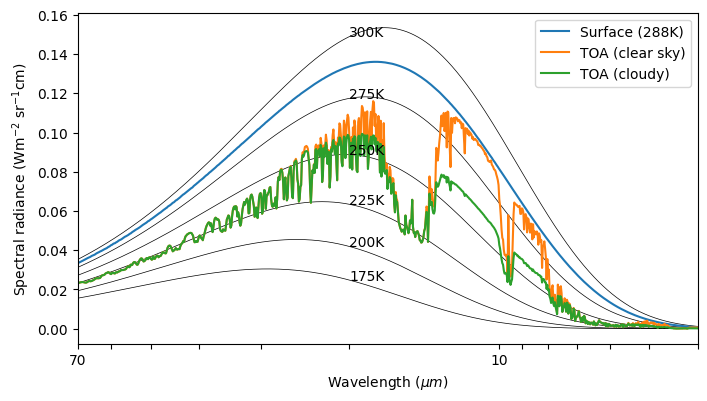

In [32]:
slrt = RadTran(LIBRADTRAN_FOLDER)
slrt.options['rte_solver'] = 'disort'
slrt.options['source'] = 'solar'
slrt.options['wavelength'] = '200 2600'
slrt.options['output_user'] = 'lambda eglo eup edn edir'
slrt.options['zout'] = '0 5 TOA'
slrt.options['albedo'] = '0'
slrt.options['umu'] = '-1.0 1.0'
slrt.options['quiet'] = ''
slrt.options['sza'] = '0'

tlrt = copy.deepcopy(slrt)
tlrt.options['rte_solver'] = 'disort'
tlrt.options['source'] = 'thermal'
tlrt.options['output_user'] = 'lambda edir eup uu'
tlrt.options['wavelength'] = '2500 80000'
tlrt.options['mol_abs_param'] = 'reptran fine'
tlrt.options['sza'] = '0'

# Add in a cloud
# slrt_cld = copy.deepcopy(slrt)
# slrt_cld.cloud = {'z': np.array([4, 3.7]),
#                   'lwc': np.array([0, 0.5]),
#                   're': np.array([0, 20])}

tlrt_cld = copy.deepcopy(tlrt)
tlrt_cld.cloud = {'z': np.array([4, 3.7]),
                  'lwc': np.array([0, 0.5]),
                  're': np.array([0, 20])}

# Run the RT
print('Initial RT')
# sdata, sverb = slrt.run(verbose=True)
tdata, tverb = tlrt.run(verbose=True)
print('Cloud RT')
# scdata, scverb = slrt_cld.run(verbose=True)
tcdata, tcverb = tlrt_cld.run(verbose=True)
print('Done RT')

tclearsurf = scipy.interpolate.interp1d(np.log(tdata[::3, 0]), tdata[::3, 2])
tcleartoa = scipy.interpolate.interp1d(np.log(tdata[2::3, 0]), tdata[2::3, 2])
tcldtoa = scipy.interpolate.interp1d(np.log(tcdata[2::3, 0]), tcdata[2::3, 2])

xtlocs = np.linspace(np.log(tdata[0, 0]), np.log(tdata[-1, 0]), 1000)

wvlticks = [(list(range(200, 1000, 100))+
             list(range(1000, 10000, 1000))+
             list(range(10000, 71000, 10000))),
            (['0.2']+['']*7+
             ['1']+['']*8+
             ['10']+['']*5+['70'])]

plt.plot(xtlocs, tclearsurf(xtlocs)/np.pi, label='Surface (288K)')
plt.plot(xtlocs, tcleartoa(xtlocs)/np.pi, label='TOA (clear sky)')
plt.plot(xtlocs, tcldtoa(xtlocs)/np.pi, label='TOA (cloudy)')
for t in [300, 275, 250, 225, 200, 175]:
    plt.plot(xtlocs, 100*np.exp(2*xtlocs)*1e-18*
             planck_function(
                 t,
                 wavelength=np.exp(xtlocs)*1e-9), c='k', lw=0.5, zorder=-1)
    plwvl = wvlticks[0][-6]
    plt.text(np.log(plwvl), 100*plwvl**2*1e-18*
             planck_function(
                 t,
                 wavelength=plwvl*1e-9), str(t)+'K')

plt.xticks(np.log(wvlticks[0]), wvlticks[1])
plt.xlim(np.log(70000), np.log(4000))
plt.xlabel(r'Wavelength ($\mu m$)')
plt.ylabel(r'Spectral radiance (Wm$^{-2}$ sr$^{-1}$cm)')
plt.legend()

fig = plt.gcf()
fig.set_size_inches(8, 4.3)